# MOGDx 

In [29]:
import argparse
import pandas as pd
import numpy as np
import os
import sys  
sys.path.insert(0, './MAIN/')
from utils import *
from GNN_MME import *
from train import *
import preprocess_functions

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold 
import networkx as nx
import torch
from datetime import datetime
import joblib
import warnings
import gc
warnings.filterwarnings("ignore")

print("Finished Library Import \n")

Finished Library Import 



In [30]:
data_input = './data/TCGA/BRCA/'
snf_net = 'miRNA_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

Using cuda device
Total = 47.6Gb 	 Reserved = 1.7Gb 	 Allocated = 0.9Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=1601, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=16, bias=True)
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
    )
  )
  (gcnlayers): ModuleList(
    (0): GraphConv(in=64, out=32, normalization=both, activation=None)
    (1): GraphConv(in=32, out=5, normalization=both, activation=None)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
)
Graph wi

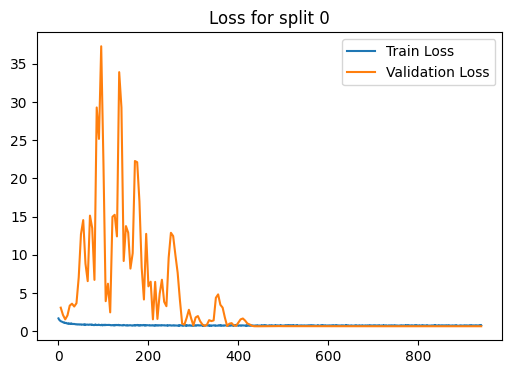

Fold : 1 | Test Accuracy = 0.7474 | F1 = 0.7066 
Total = 47.6Gb 	 Reserved = 1.7Gb 	 Allocated = 0.0Gb
Clearing gpu memory
Total = 47.6Gb 	 Reserved = 0.1Gb 	 Allocated = 0.0Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=1601, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=16, bias=True)
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
    )
  )
  (gcnlayers): ModuleList(
    (0): GraphConv(in=64, out=32, normalization=both, activation=None)
    (1): GraphConv(in=32, out=5, normalization=both, activation=None)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dro

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input + 'raw/' , ['miRNA' ] , target , index_col)

graph_file = data_input + 'Networks/' + snf_net
g = nx.read_graphml(graph_file)

meta = meta.loc[sorted(meta.index)]

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

subjects_list = [list(set(g.nodes) & set(datModalities[mod].index)) for mod in datModalities]
h = [torch.from_numpy(datModalities[mod].loc[subjects_list[i]].to_numpy(dtype=np.float32)).to(device) for i , mod in enumerate(datModalities) ]
MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

del datModalities
gc.collect()

labels = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64)).to(device)
output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GCN_MME(MME_input_shapes , [16] , 64 , [32]  , len(meta.unique())).to(device)
    print(model)
    print(g)

    train_index , val_index = train_test_split(
        train_index, train_size=0.8, test_size=None, stratify=meta.iloc[train_index]
        )

    loss_plot = train(g, h , subjects_list , train_index , val_index , device ,  model , labels , 2000 , 1e-3 , 100)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    test_output_metrics = evaluate(test_index , device , g , h , subjects_list , model , labels )

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-1][test_index])
    test_labels.extend(labels[test_index])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
display_label = meta.astype('category').cat.categories
for pred in all_predictions_conf.argmax(1)  : 
    node_predictions.append(display_label[pred])

tst = pd.DataFrame({'Actual' : meta.loc[list(nx.get_node_attributes(g, 'idx').keys())] , 'Predicted' : node_predictions})